In this notebook, we define that help mitigating the keypoints noise.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
from speed_trapv3.sampling import video_to_frames

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
f = open("/code/data/datasets/common_hall/tracking_outputs/framewise_aggregation.json")
frame_to_predictions_map = json.load(f)
f = open("/code/data/datasets/common_hall/tracking_outputs/objectwise_aggregation.json")
objects_to_predictions_map = json.load(f)['annotations'] #the object_id attribute of frame_to_predictions_map are the keys of object_to_predictions_map

In [3]:
#get all the backtire keypoints for object 0
tire_dict = {}
for i in range(len(objects_to_predictions_map)):    
    tire_dict[f'obj_{i}_back_x'] = []
    tire_dict[f'obj_{i}_back_y'] = []
    tire_dict[f'obj_{i}_front_x'] = []
    tire_dict[f'obj_{i}_front_y'] = []
col_names = list(tire_dict.keys())

In [4]:
#Convert the video into frames
src = "/code/data/datasets/common_hall/source_video/25_resampled_vid.mp4"
dst = "/code/data/datasets/temp_imgs3"
# video_to_frames(src, dst)

In [5]:
def validate_inclusion(_x, _y, _cx, _cy, _r):
    return (_x - _cx)**2 + (_y -_cy)**2 < _r**2

In [16]:
frame_path = '/code/data/datasets/frame_imgs'
frame_list = os.listdir(frame_path)
frame_border = True
rule0 = True
rule1 = True
rule2 = True
for frame_idx in range(len(frame_to_predictions_map)):
    frame = cv2.imread(str(Path(frame_path)/f'{frame_idx}.jpg'))
    if frame_border:
        img = cv2.rectangle(frame, (450, 200), (1280, 720), (0, 255, 0), thickness=4)
    objects_per_frame = frame_to_predictions_map[frame_idx]['annotations']
    for obj_idx in range(len(objects_per_frame)):
        back_tire_x = objects_per_frame[obj_idx]['keypoints'][0][0]
        back_tire_y =objects_per_frame[obj_idx]['keypoints'][0][1]
        front_tire_x = objects_per_frame[obj_idx]['keypoints'][1][0]
        front_tire_y = objects_per_frame[obj_idx]['keypoints'][1][1]
        x1, y1, x2, y2 = objects_per_frame[obj_idx]['bounding_box']
        #rule #0
        if rule0 == True:
            frame_save_path = Path('/code/data/datasets/rule0_imgs')
            if x1 < 600 or x1 >= 1100:
                back_tire_x = -100
                back_tire_y = -100
                front_tire_x = -100
                front_tire_y = -100

        #rule #1
        if rule1 == True:
            frame_save_path = Path('/code/data/datasets/rule1_imgs')
            if (back_tire_y <= y1 + int((y2 - y1)/2)):
                back_tire_x = -100
                back_tire_y = -100
            if (front_tire_y <= y1 + int((y2 - y1)/2)):
                front_tire_x = -100
                front_tire_y = -100
        #rule #2
        if rule2 == True:
            frame_save_path = Path('/code/data/datasets/rule2_imgs')
            if validate_inclusion(back_tire_x, back_tire_y, front_tire_x, front_tire_y, 20):
                if np.array(objects_per_frame[obj_idx]['keypoints_scores']).argmax() == 0:
                    front_tire_x = -100
                    front_tire_y = -100
                else:
                    back_tire_x = -100
                    back_tire_y = -100
        img = cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), thickness=4)
        img = cv2.circle(img, (int(back_tire_x), int(back_tire_y)), radius=5, color=(0, 0, 255), thickness=-1) #Blue: Backtire
        img = cv2.circle(img, (int(front_tire_x), int(front_tire_y)), radius=5, color=(255, 0, 0), thickness=-1) #Red Front tire
        cv2.imwrite(os.path.join(frame_save_path, f'{frame_idx}.jpg'), img)

With no rules

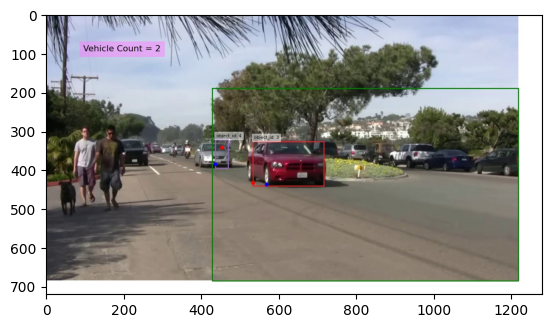

In [45]:
frame_idx = 125
no_rule = cv2.imread(str(Path("/code/data/datasets/temp_imgs")/f'{frame_idx}.jpg'))
im_rgb = cv2.cvtColor(no_rule, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb);

Rule 0: Remove any keypoints in vehicles where x1 <600 or x1 >= 1100

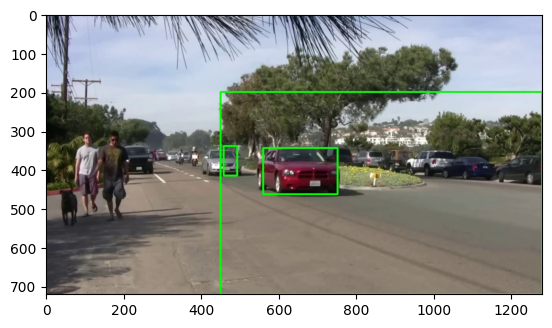

In [46]:
rule0 = cv2.imread(str(Path("/code/data/datasets/rule0_imgs")/f'{frame_idx}.jpg'))
im_rgb = cv2.cvtColor(rule0, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb);

Rule 1: If a keypoint is located in the upper half of the bounding box, remove it.

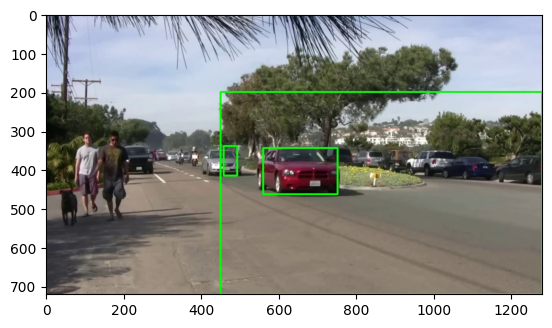

In [47]:
rule1 = cv2.imread(str(Path("/code/data/datasets/rule1_imgs")/f'{frame_idx}.jpg'))
im_rgb = cv2.cvtColor(rule1, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb);

Rule 2: Draw a circle around the front tire keypoint and if the back tire is located inside of the circle, keep the tire that has the highest sigmoid score. Throw the other one away!!


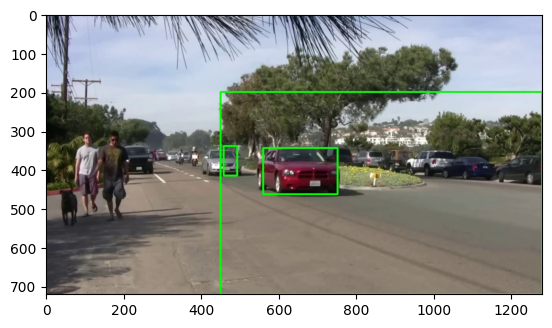

In [48]:
rule2 = cv2.imread(str(Path("/code/data/datasets/rule2_imgs")/f'{frame_idx}.jpg'))
im_rgb = cv2.cvtColor(rule2, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb);